In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [5]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random


In [7]:
np.random.seed(0)

In [8]:
with open('german-traffic-signs/train.p', 'rb')as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb')as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb')as f:
    test_data = pickle.load(f)
    
print(type(train_data))

x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']


<class 'dict'>


In [9]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [10]:
assert(x_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(x_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(x_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(x_train.shape[1:] == (32,32,3)), "The dimensions of images are not 32*32*3"
assert(x_val.shape[1:] == (32,32,3)), "The dimensions of images are not 32*32*3"
assert(x_test.shape[1:] == (32,32,3)), "The dimensions of images are not 32*32*3"


In [11]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

<ipython-input-12-24af4a1ba4a5>:7: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


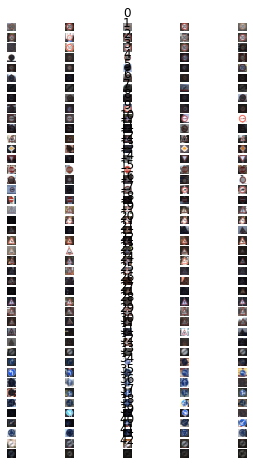

In [12]:
num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 8))
fig.tight_layout()
for i in range(cols):
    for j in range(num_classes):
        x_selected = x_train[y_train == j]
        
        #axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j))
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


<function matplotlib.pyplot.show(close=None, block=None)>

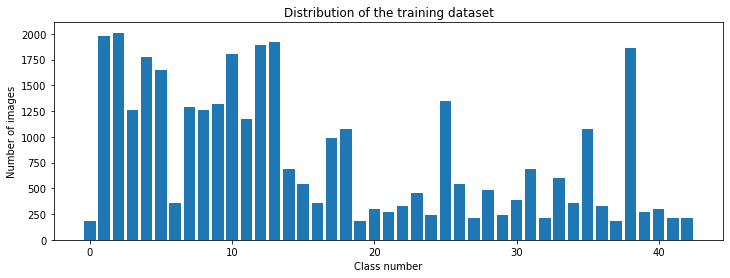

In [13]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show

(32, 32, 3)
36


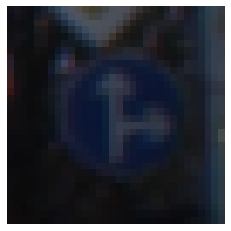

In [14]:
import cv2

plt.imshow(x_train[1008])
plt.axis("off")
print(x_train[1008].shape)
print(y_train[1008])

(32, 32)


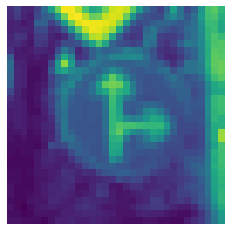

In [15]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(x_train[1008])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


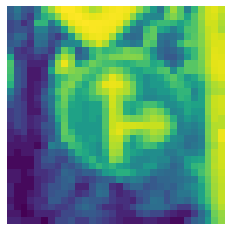

In [16]:
#hist avg tech for standard lighting throughout
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [17]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img /255
    return img

x_train = np.array(list(map(preprocessing, x_train)))
x_val = np.array(list(map(preprocessing, x_val)))
x_test = np.array(list(map(preprocessing, x_test)))

(34799, 32, 32)


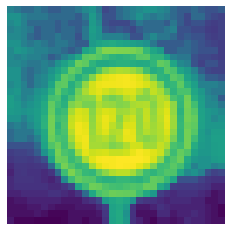

In [18]:
plt.imshow(x_train[random.randint(0, len(x_train)-1 )])
plt.axis("off")
print(x_train.shape)

In [19]:
x_train = x_train.reshape(34799, 32, 32, 1)
x_test = x_test.reshape(12630, 32, 32, 1)
x_val = x_val.reshape(4410, 32, 32, 1)

In [20]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                  height_shift_range = 0.1,
                  zoom_range = 0.2,
                  shear_range = 0.1,
                  rotation_range = 10)
datagen.fit(x_train)

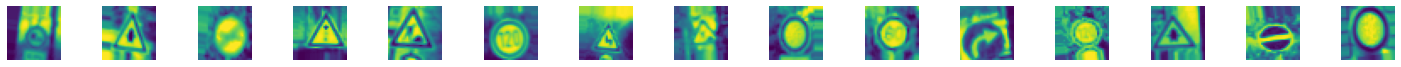

In [21]:
batches = datagen.flow(x_train, y_train, batch_size=20)
x_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(x_batch[i].reshape(32,32))
    axs[i].axis("off")

In [22]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [23]:
y_train = to_categorical(y_train, 43 )
y_test = to_categorical(y_test, 43 )
y_val = to_categorical(y_val, 43 )

In [26]:
def modified_model():
    model = Sequential()
    model.add(Conv2D(60, (5,5), input_shape=(32, 32, 1), activation = 'relu'))
    model.add(Conv2D(60, (5,5), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(30, (3,3), activation = 'relu'))
    model.add(Conv2D(30, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(43, activation = 'softmax'))
    
    model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model
    

In [27]:
model = modified_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

In [29]:
#history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            #steps_per_epoch=2000,
                            #epochs=10,
                            #validation_data=(X_val, y_val), shuffle = 1)

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=50),
                            steps_per_epoch=x_train.shape[0]/50,
                            epochs=10,
                            validation_data=(x_val, y_val), shuffle = 1)

<ipython-input-29-aef424553973>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=50),


Epoch 1/10
695/695 [==============================] - 66s 95ms/step - loss: 1.7177 - accuracy: 0.5137 - val_loss: 0.3377 - val_accuracy: 0.9086
Epoch 2/10
695/695 [==============================] - 81s 117ms/step - loss: 0.5665 - accuracy: 0.8258 - val_loss: 0.1351 - val_accuracy: 0.9583
Epoch 3/10
695/695 [==============================] - 83s 119ms/step - loss: 0.3582 - accuracy: 0.8894 - val_loss: 0.0829 - val_accuracy: 0.9744
Epoch 4/10
695/695 [==============================] - 90s 129ms/step - loss: 0.2696 - accuracy: 0.9171 - val_loss: 0.1265 - val_accuracy: 0.9624
Epoch 5/10
695/695 [==============================] - 87s 125ms/step - loss: 0.2207 - accuracy: 0.9305 - val_loss: 0.0771 - val_accuracy: 0.9737
Epoch 6/10
695/695 [==============================] - 84s 120ms/step - loss: 0.1875 - accuracy: 0.9406 - val_loss: 0.0568 - val_accuracy: 0.9844
Epoch 7/10
695/695 [==============================] - 85s 122ms/step - loss: 0.1650 - accuracy: 0.9491 - val_loss: 0.0596 - val_acc

Text(0.5, 0, 'epoch')

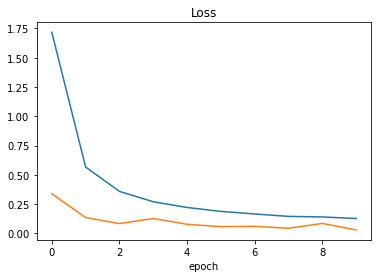

In [30]:
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

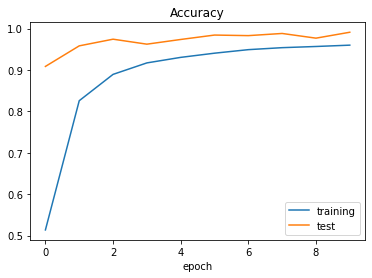

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')


In [32]:
# TODO: Evaluate model on test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.13754871487617493
Test accuracy: 0.9651623368263245


(32, 32)
predicted sign:  [29]


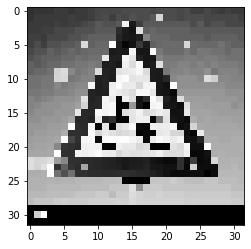

In [33]:
#fetch image 5
 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
 
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
predict_x = model.predict(img)
class_x = np.argmax(predict_x, axis=1)
print("predicted sign: ", class_x)


(32, 32)
predicted sign:  [38]


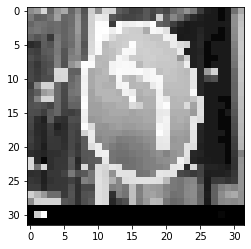

In [34]:
#fetch image 2
 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
 
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
predict_x = model.predict(img)
class_x = np.argmax(predict_x, axis=1)
print("predicted sign: ", class_x)

(32, 32)
predicted sign:  [1]


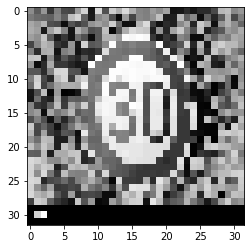

In [35]:

#fetch image 1
 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
 
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
predict_x = model.predict(img)
class_x = np.argmax(predict_x, axis=1)
print("predicted sign: ", class_x)

(32, 32)
predicted sign:  [23]


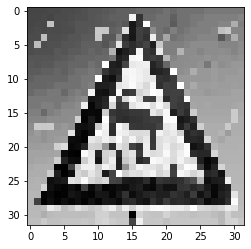

In [36]:
#fetch image 3
 
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
 
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
predict_x = model.predict(img)
class_x = np.argmax(predict_x, axis=1)
print("predicted sign: ", class_x)

(32, 32)
predicted sign:  [13]


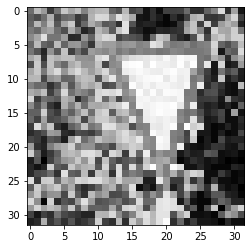

In [37]:
#fetch image 4
 
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
 
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
predict_x = model.predict(img)
class_x = np.argmax(predict_x, axis=1)
print("predicted sign: ", class_x)